# Section 1: binary phase evaluation (fixed parameters)

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = 2 \pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

Time dependent: in this case only the phase has an analytical form, which is derived from the fit of the outcomde of the HaloFeedback code evolving the static dress as the binary evolves. 

\begin{equation}
\label{eq:phi_time}
    \Phi(f) = \Phi_{\mathrm{GW}} \cdot (1 - \eta \cdot y^{-\lambda}(1 - 2F_{1}))
\end{equation}

where the quantities $\eta$, $\lambda$ and $y$ are derived from the frequencies and other constants set in the data (see below for the implementation), while $2F_1$ is the $\textbf{gaussian hypergeometric}$ function, and $\Phi_{\mathrm{GW}}$ is the vacuum phase to coalescence that comes from integrating the below quantity. If we reverse the process to find $\Phi(f)$, it is possible to find an expression for $\dot{r}_{\mathrm{eff, dm}}$, but I will not report it here.

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

### Libraries and classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad_vec, simpson
from scipy.special import hyp2f1, betainc
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from scipy.integrate import cumulative_trapezoid, cumulative_simpson
from scipy.interpolate import CubicSpline
from scipy.integrate import quad, solve_ivp, simps
from scipy.interpolate import interp1d

In [2]:
import environments_handy_functions

# Reload libraries (in case you change something)
import importlib
importlib.reload(environments_handy_functions)

from environments_handy_functions import (
    df_dt,  
    find_grid, 
    time_to_coal_cumul,  
    phase_f_cumul, 
    f_1yr, 
    h_0, 
    mycalculate_SNR, 
    amplitude, 
    Psi,
    myVacuumBinary, myAccretionDisk, myDarkMatter, myCombination)

In [3]:
G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s

In [4]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "14"

# Section 1: binary phase evaluation VARYING parameters

We work varying parameters one by one. More specifically we'll change:

### For the accretion disk:

- The $\gamma$ parameter $\rightarrow \ [-0.4, -0.7]$ ($\beta$-disk regime), possibly changing the upper threshold to match an $\alpha$-disk. Particularly, the scaling relations go as: 

$$\Sigma_\alpha = 5.14 \cdot 10^3 (\frac{\alpha}{0.1})^{-1} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{-1} (\frac{r}{10 M_1})^{3/2} \ \text{kg m}^{-2} ;$$

$$\Sigma_\beta = 2.1 \cdot 10^7 (\frac{\alpha}{0.1})^{-4/5} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{3/5} (\frac{M_1}{10^6 M_{\odot}})^{1/5} (\frac{r}{10 M_1})^{-3/5}.$$

- $\Sigma_0$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 

### For the effective dark matter spike:

- The $\gamma_s$ parameter $\rightarrow \ [2, 2.5]$;
- $\rho_m$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 


We look to see how changing just one of these parameters will affect the inspiral. If the dephasing $\Delta\Phi$ increases, this means that the environmental effect is more likely to be detected, while the opposite indicates that a vacuum model wil still be compatible with the phase measured. 

In [6]:
# Fix parameters:

m1 = 1e5 * MSUN #1.4e3 * m_sun
m2 = 10 * MSUN #1.4 * m_sun
q = m2/m1
M_tot = m1 + m2
mu = m1 * m2 / M_tot
chirp_mass = (m1 * m2)**(3/5) / (M_tot)**(1/5)

# Fix environments:

# Spike

rho6 = 1.17e17 * MSUN / PC**3
r6 =  PC / 1e6
gammas = 7/3
epsv = 0.58
logL = 1 / q**(1/2)

# Accretion disk

r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5e10 / Mach**2
alpha = -1/2

In [27]:
# declare envs: 

_VB = myVacuumBinary(m1=m1,
    m2=m2,
    dist=100e6 * PC, 
    chirp_mass=chirp_mass)

_AD = myAccretionDisk(mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=chirp_mass)

_DM = myDarkMatter(m1=m1, 
    m2=m2, 
    dist=100e6 * PC, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv, 
    chirp_mass=chirp_mass)

_CC = myCombination(mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=chirp_mass, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv)

In [8]:
# Build grid of vals

f_LISA = 1e-3 # Hz
r_max = _VB.radius(f_LISA)

r_isco = 6 * m1 * G / C**2
f_isco = _VB.frequency(r_isco)

print('isco frequency', f_isco)

# set grid of radial distances
r_grid = np.linspace(r_isco, r_max, int(1e4))

freqs = _VB.frequency(r_grid)

isco frequency 0.04397229680540114


## Accretion disk:

In [38]:
# Build array of gamma values, m_s, and sigma_0s

alpha_vals = np.linspace(-0.7, 1.5, 20)
m1_vals = np.logspace(4, 6, 20)
sigma0_vals = np.logspace(7, 11, 20)

print("Alphas: ", alpha_vals)
print("M1s: ", m1_vals)
print("Sigma0s: ", sigma0_vals)

Alphas:  [-0.7        -0.58421053 -0.46842105 -0.35263158 -0.23684211 -0.12105263
 -0.00526316  0.11052632  0.22631579  0.34210526  0.45789474  0.57368421
  0.68947368  0.80526316  0.92105263  1.03684211  1.15263158  1.26842105
  1.38421053  1.5       ]
M1s:  [  10000.           12742.74985703   16237.76739189   20691.38081115
   26366.5089873    33598.18286284   42813.32398719   54555.94781169
   69519.27961776   88586.67904101  112883.78916847  143844.98882877
  183298.07108324  233572.14690901  297635.14416313  379269.01907323
  483293.02385718  615848.21106603  784759.97035146 1000000.        ]
Sigma0s:  [1.00000000e+07 1.62377674e+07 2.63665090e+07 4.28133240e+07
 6.95192796e+07 1.12883789e+08 1.83298071e+08 2.97635144e+08
 4.83293024e+08 7.84759970e+08 1.27427499e+09 2.06913808e+09
 3.35981829e+09 5.45559478e+09 8.85866790e+09 1.43844989e+10
 2.33572147e+10 3.79269019e+10 6.15848211e+10 1.00000000e+11]


### Varying $\alpha$:

In [39]:
# Initialize system

accretion_disk_alpha = [myAccretionDisk(mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha_i, 
    chirp_mass=chirp_mass) for alpha_i in alpha_vals]

combo_alpha = [myCombination(mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha_i, 
    chirp_mass=chirp_mass, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv) for alpha_i in alpha_vals]

In [40]:
# Calculate phase to coalescence

phase_gw = phase_f_cumul(freqs, _VB) # note it's negative
phase_acc = [phase_f_cumul(freqs, accretion_disk_alpha[i]) for i in range(0, len(accretion_disk_alpha))]
phase_all = [phase_f_cumul(freqs, combo_alpha[i]) for i in range(0, len(accretion_disk_alpha))]

In [41]:
# Fiducial value

phase_acc_fiducial = phase_f_cumul(freqs, _AD)
phase_dm_fiducial = phase_f_cumul(freqs, _DM)
phase_all_fiducial = phase_f_cumul(freqs, _CC)

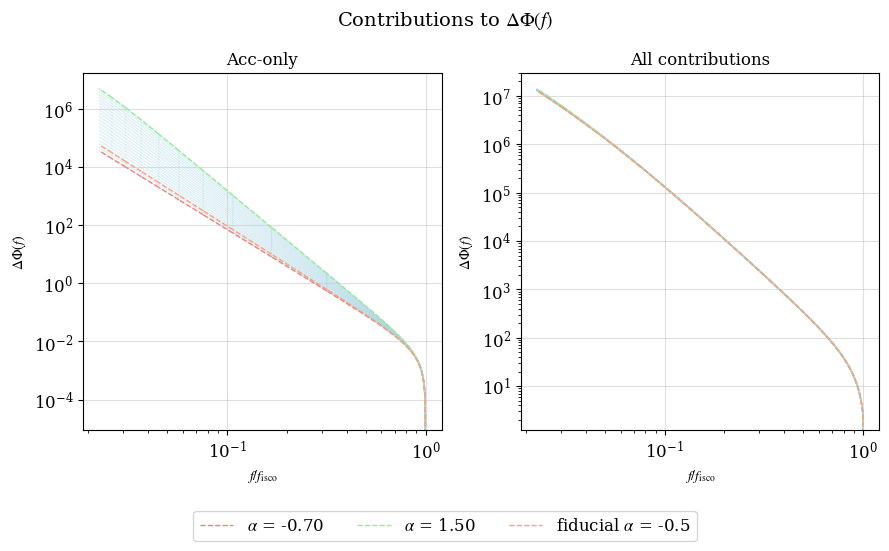

In [42]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phase_acc)):
    axs[0].loglog(freqs/f_isco, phase_acc[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs/f_isco, phase_acc[0] - phase_gw, label=fr'$\alpha$ = {alpha_vals[0]:.2f}', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs/f_isco, phase_acc[-1] - phase_gw, label=fr'$\alpha$ = {alpha_vals[-1]:.2f}', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_acc_fiducial - phase_gw, label=fr'fiducial $\alpha$ = -0.5', linestyle='--', linewidth=1, c='lightsalmon')
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True, alpha=0.4)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines

for i in range(0, len(phase_acc)):
    axs[1].loglog(freqs/f_isco, phase_all[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs/f_isco, phase_all[0] - phase_gw, linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs/f_isco, phase_all[-1] - phase_gw, linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True, alpha=0.4)  # Add gridlines
axs[1].set_title('All contributions')

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/gamma_accretion_DELTA_phi.png')
plt.show()

## Varying $m_1$

In [91]:
# Initialize system

vacuum_binary_m1 = [myVacuumBinary(m1=m1_i * MSUN,
    m2=m2,
    dist=100e6 * PC, 
    chirp_mass=(m1_i * MSUN * m2)**(3/5) / (m1_i * MSUN + m2)**(1/5)) for m1_i in m1_vals]

accretion_disk_m1 = [myAccretionDisk(mach=Mach, 
    m1=m1_i * MSUN,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=(m1_i * MSUN * m2)**(3/5) / (m1_i * MSUN + m2)**(1/5)) for m1_i in m1_vals]

dark_matter_m1 = [myDarkMatter(m1=m1_i * MSUN, 
    m2=m2, 
    dist=100e6 * PC, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv, 
    chirp_mass=(m1_i * MSUN * m2)**(3/5) / (m1_i * MSUN + m2)**(1/5)) for m1_i in m1_vals]

combo_m1 = [myCombination(mach=Mach, 
    m1=m1_i * MSUN,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=(m1_i * MSUN * m2)**(3/5) / (m1_i * MSUN + m2)**(1/5), 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv) for m1_i in m1_vals]

In [92]:
# Build grid of vals

r_max_m1 = [vacuum_binary_m1[i].radius(f_LISA) for i in range(0, len(m1_vals))]

r_isco_m1 = 6 * m1_vals * MSUN * G / C**2
f_isco_m1 = [vacuum_binary_m1[i].frequency(r_isco_m1[i]) for i in range(0, len(m1_vals))]

# set grid of radial distances
r_grid_m1 = [np.linspace(r_isco_m1[i], r_max_m1[i], int(1e4)) for i in range(0, len(m1_vals))]

freqs_m1 = [vacuum_binary_m1[i].frequency(r_grid_m1[i])  for i in range(0, len(m1_vals))]

In [93]:
# Calculate phase to coalescence

phase_gw_m1 = [phase_f_cumul(freqs_m1[i], vacuum_binary_m1[i]) for i in range(0, len(m1_vals))]
phase_acc_m1 = [phase_f_cumul(freqs_m1[i], accretion_disk_m1[i]) for i in range(0, len(m1_vals))]
phase_dm_eff_m1 = [phase_f_cumul(freqs_m1[i], dark_matter_m1[i]) for i in range(0, len(m1_vals))]
phase_all_m1 = [phase_f_cumul(freqs_m1[i], combo_m1[i]) for i in range(0, len(m1_vals))]

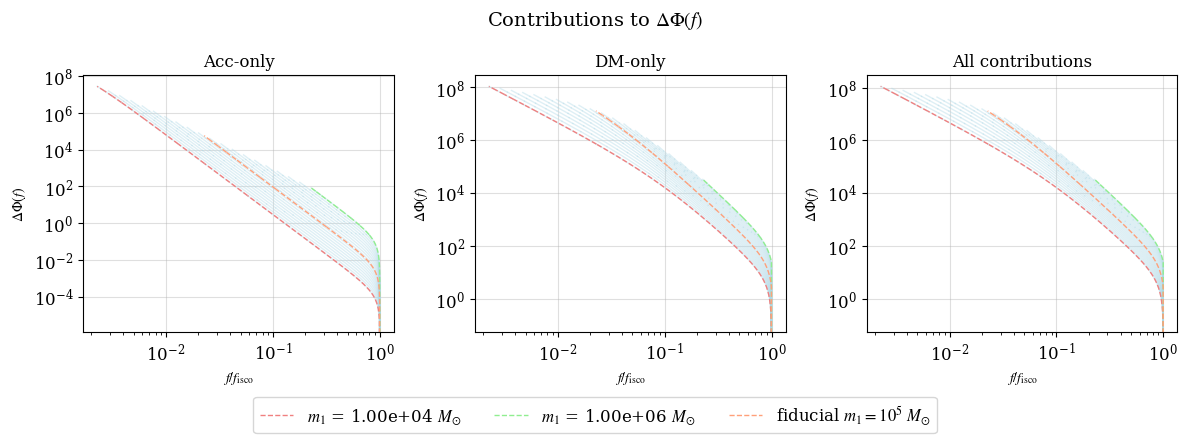

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(m1_vals)):
    axs[0].loglog(freqs_m1[i]/f_isco_m1[i], phase_acc_m1[i] - phase_gw_m1[i], c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs_m1[0]/f_isco_m1[0], -phase_gw_m1[0] + phase_acc_m1[0], label=f'$m_1$ = {m1_vals[0]:.2e} $M_{{\odot}}$', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs_m1[-1]/f_isco_m1[-1], -phase_gw_m1[-1] + phase_acc_m1[-1], label=f'$m_1$ = {m1_vals[-1]:.2e} $M_{{\odot}}$', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_acc_fiducial - phase_gw, label=f'fiducial $m_1 = 10^5 \ M_{{\odot}}$', linestyle='--', linewidth=1, c='lightsalmon')
#axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True, alpha=0.4)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(m1_vals)):
    axs[1].loglog(freqs_m1[i]/f_isco_m1[i], -phase_gw_m1[i] + phase_dm_eff_m1[i], c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs_m1[0]/f_isco_m1[0], -phase_gw_m1[0] + phase_dm_eff_m1[0], linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs_m1[-1]/f_isco_m1[-1], -phase_gw_m1[-1] + phase_dm_eff_m1[-1], linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_dm_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
#axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True, alpha=0.4)  # Add gridlines
axs[1].set_title('DM-only')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(m1_vals)):
    axs[2].loglog(freqs_m1[i]/f_isco_m1[i], - phase_gw_m1[i] + phase_all_m1[i], c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[2].loglog(freqs_m1[0]/f_isco_m1[0],  -phase_gw_m1[0] + phase_all_m1[0], linestyle='--', linewidth=1, c='lightcoral')
axs[2].loglog(freqs_m1[-1]/f_isco_m1[-1], -phase_gw_m1[-1] + phase_all_m1[-1], linestyle='--', linewidth=1, c='lightgreen')
axs[2].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
#axs[2].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[2].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[2].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[2].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[2].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[2].grid(True, alpha=0.4)  # Add gridlines
axs[2].set_title('All contributions')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/m1_DELTA_phi.png')
plt.show()

### Varying $\Sigma_0$

In [95]:
accretion_disk_sigma0 = [myAccretionDisk(mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0_i/Mach**2, 
    alpha=alpha, 
    chirp_mass=chirp_mass) for sigma0_i in sigma0_vals]

combo_sigma0 = [myCombination(mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0_i/Mach**2, 
    alpha=alpha, 
    chirp_mass=chirp_mass, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv) for sigma0_i in sigma0_vals]

In [96]:
# Calculate phase to coalescence

phase_acc_sigma0 = [phase_f_cumul(freqs, accretion_disk_sigma0[i]) for i in range(0, len(sigma0_vals))]
phase_all_sigma0 = [phase_f_cumul(freqs, combo_sigma0[i]) for i in range(0, len(sigma0_vals))]

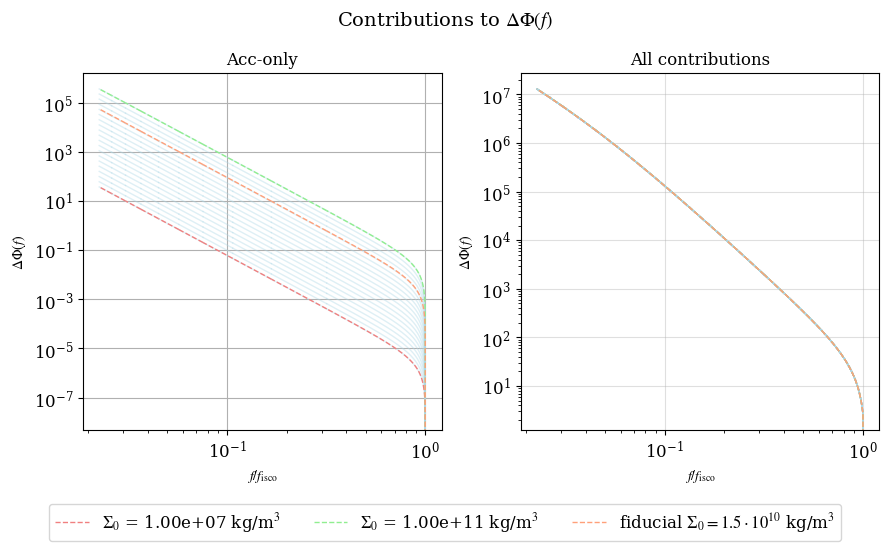

In [97]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phase_all_sigma0)):
    axs[0].loglog(freqs/f_isco, phase_acc_sigma0[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs/f_isco, phase_acc_sigma0[0] - phase_gw, label=f'$\Sigma_0$ = {sigma0_vals[0]:.2e} kg/m$^3$', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs/f_isco, phase_acc_sigma0[-1] - phase_gw, label=f'$\Sigma_0$ = {sigma0_vals[-1]:.2e} kg/m$^3$', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_acc_fiducial - phase_gw, label=f'fiducial $\Sigma_0 = 1.5 \cdot 10^{{10}}$ kg/m$^3$', linestyle='--', linewidth=1, c='lightsalmon')
#axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phase_all_sigma0)):
    axs[1].loglog(freqs/f_isco, phase_all_sigma0[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs/f_isco, phase_all_sigma0[0] - phase_gw, linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs/f_isco, phase_all_sigma0[-1] - phase_gw, linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
#axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True, alpha=0.4)  # Add gridlines
axs[1].set_title('All contributions')
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/sigma0_accretion_DELTA_phi.png')
plt.show()

## Dark matter spike

I still keep here the static profile, while in the other notebook I try to implement a version for the non-static profile.

In [98]:
# Build array of gamma_s values and rho_s

gammas_vals = np.linspace(2, 2.5, 20)
rhodm_vals = np.logspace(15, 18, 20)

print("Gammass: ", gammas_vals)
print("Rhodms: ", rhodm_vals)

Gammass:  [2.         2.02631579 2.05263158 2.07894737 2.10526316 2.13157895
 2.15789474 2.18421053 2.21052632 2.23684211 2.26315789 2.28947368
 2.31578947 2.34210526 2.36842105 2.39473684 2.42105263 2.44736842
 2.47368421 2.5       ]
Rhodms:  [1.00000000e+15 1.43844989e+15 2.06913808e+15 2.97635144e+15
 4.28133240e+15 6.15848211e+15 8.85866790e+15 1.27427499e+16
 1.83298071e+16 2.63665090e+16 3.79269019e+16 5.45559478e+16
 7.84759970e+16 1.12883789e+17 1.62377674e+17 2.33572147e+17
 3.35981829e+17 4.83293024e+17 6.95192796e+17 1.00000000e+18]


### Varying $\gamma_s$

In [99]:
dark_matter_gammas = [myDarkMatter(m1=m1, 
    m2=m2, 
    dist=100e6 * PC, 
    q=q, 
    gammas=gammas_i, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv, 
    chirp_mass=chirp_mass) for gammas_i in gammas_vals]

combo_gammas = [myCombination(mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=chirp_mass, 
    q=q, 
    gammas=gammas_i, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv) for gammas_i in gammas_vals]

In [100]:
# Calculate phase to coalescence

phase_dm_gammas = [phase_f_cumul(freqs, dark_matter_gammas[i]) for i in range(0, len(gammas_vals))]
phase_all_gammas= [phase_f_cumul(freqs, combo_gammas[i]) for i in range(0, len(gammas_vals))]

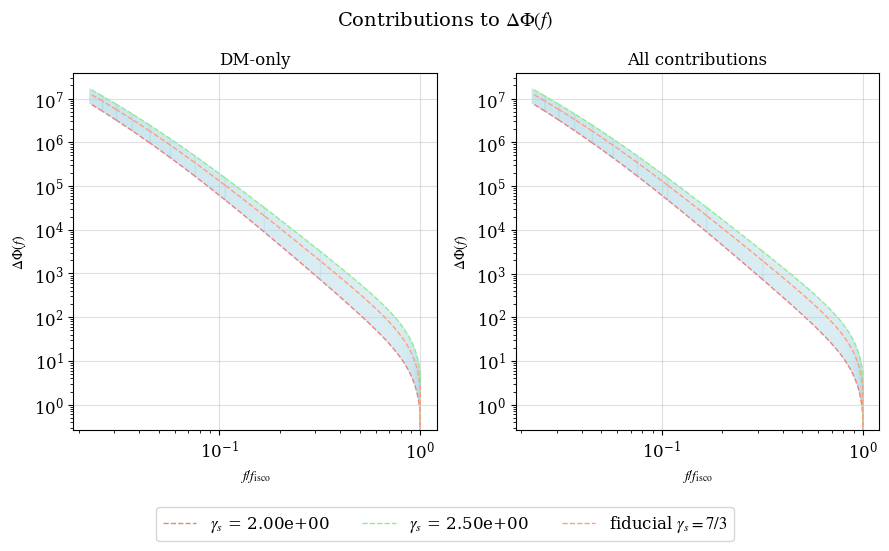

In [101]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phase_dm_gammas)):
    axs[0].loglog(freqs/f_isco, phase_dm_gammas[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs/f_isco, phase_dm_gammas[0] - phase_gw, label=f'$\gamma_s$ = {gammas_vals[0]:.2e}', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs/f_isco, phase_dm_gammas[-1] - phase_gw, label=f'$\gamma_s$ = {gammas_vals[-1]:.2e}', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_dm_fiducial - phase_gw, label=f'fiducial $\gamma_s = 7/3$', linestyle='--', linewidth=1, c='lightsalmon')
#axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True, alpha=0.4)  # Add gridlines
axs[0].set_title('DM-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phase_all_gammas)):
    axs[1].loglog(freqs/f_isco, phase_all_gammas[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs/f_isco, phase_all_gammas[0] - phase_gw, linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs/f_isco, phase_all_gammas[-1] - phase_gw, linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
#axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True, alpha=0.4)  # Add gridlines
axs[1].set_title('All contributions')
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/gamma_dm_DELTA_phi.png')
plt.show()

### Varying $\rho_s$

In [102]:
dark_matter_rhos = [myDarkMatter(m1=m1, 
    m2=m2, 
    dist=100e6 * PC, 
    q=q, 
    gammas=gammas, 
    rho6=rhodm_i * MSUN / PC**3, 
    r6=r6, 
    epsv=epsv, 
    chirp_mass=chirp_mass) for rhodm_i in rhodm_vals]

combo_rhos = [myCombination(mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=chirp_mass, 
    q=q, 
    gammas=gammas, 
    rho6=rhodm_i * MSUN / PC**3, 
    r6=r6, 
    epsv=epsv) for rhodm_i in rhodm_vals]

In [103]:
# Calculate phase to coalescence

phase_dm_rhos = [phase_f_cumul(freqs, dark_matter_rhos[i]) for i in range(0, len(rhodm_vals))]
phase_all_rhos= [phase_f_cumul(freqs, combo_rhos[i]) for i in range(0, len(rhodm_vals))]

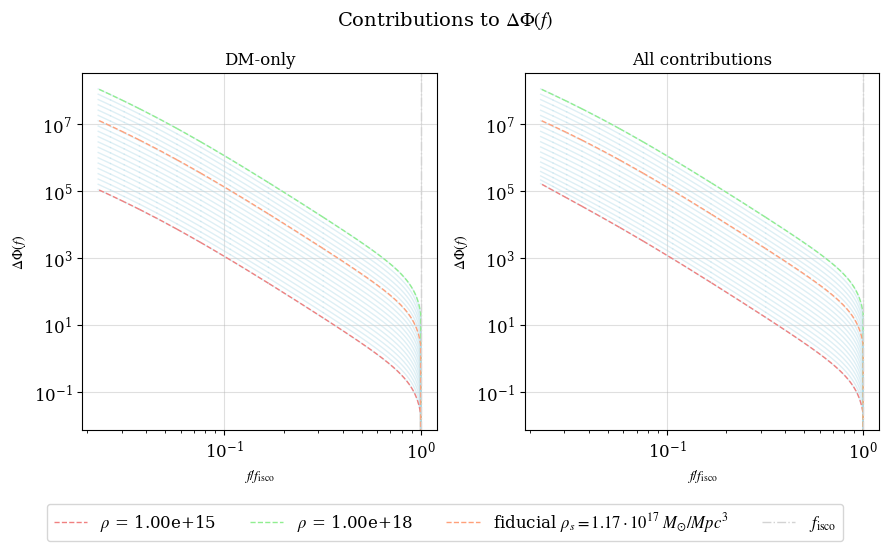

In [104]:


fig, axs = plt.subplots(1, 2, figsize=(9, 5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phase_dm_rhos)):
    axs[0].loglog(freqs/f_isco, phase_dm_rhos[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs/f_isco, phase_dm_rhos[0] - phase_gw, label=fr'$\rho$ = {rhodm_vals[0]:.2e}', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs/f_isco, phase_dm_rhos[-1] - phase_gw, label=fr'$\rho$ = {rhodm_vals[-1]:.2e}', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_dm_fiducial - phase_gw, label=fr'fiducial $\rho_s = 1.17 \cdot 10^{{17}} \ M_{{\odot}} / Mpc^{{3}}$', linestyle='--', linewidth=1, c='lightsalmon')
axs[0].axvline(x=1, c='lightgrey', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].grid(True, alpha=0.4)
axs[0].set_title('DM-only')

for i in range(0, len(phase_all_rhos)):
    axs[1].loglog(freqs/f_isco, phase_all_rhos[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs/f_isco, phase_all_rhos[0] - phase_gw, linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs/f_isco, phase_all_rhos[-1] - phase_gw, linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
axs[1].axvline(x=1, c='lightgrey', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].grid(True, alpha=0.4)
axs[1].set_title('All contributions')

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/rho_dm_DELTA_phi.png')
plt.show()

## Energy loss analysis

In the case of the accretion disk we saw that if the $\gamma$ coefficient is positive, then a sort of damp occurs in the dephasing plot. To assess the possible physics behind such behaviour, we try to see if the frequency at which the damping occurs corresponds to when the energy loss by the binary passes from an accretion-dominated regime to a GW-dominated one. 

In [105]:
def energy_loss_f(r, r_dot):
    
    return G * m1 * m2 * r_dot / (2 * r**2)

In [107]:
# Set a larger grid to see effect

r_grid_new = np.linspace(r_isco, 150 * r_isco, 10000)
freqs_new = _VB.frequency(r_grid_new)

In [108]:
r_dot_acc_gamma = (_AD.dot_r_acc(r_grid_new)) 
r_dot_gw_gamma = (_VB.dot_r_gw(r_grid_new)) 

In [109]:
phase_gw_new = phase_f_cumul(freqs, _VB) 
phase_acc_new= phase_f_cumul(freqs, _AD) 

phi_c = phase_acc_new - phase_gw_new

In [110]:
energy_loss_acc = energy_loss_f(r_grid_new, r_dot_acc_gamma)
energy_loss_vac = energy_loss_f(r_grid_new, r_dot_gw_gamma)

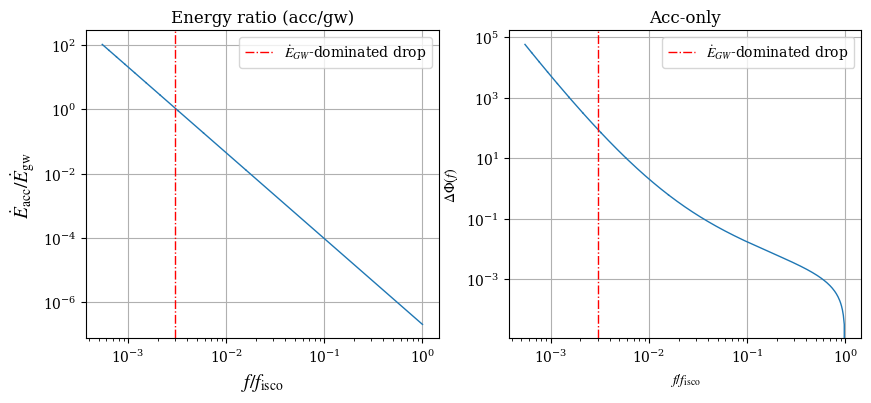

In [111]:
drop_estimate = np.where(energy_loss_acc/energy_loss_vac < 1.1)[0][-1]

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].loglog(freqs_new/f_isco, energy_loss_acc/energy_loss_vac, linewidth=1)
axs[0].axvline(x=freqs_new[drop_estimate]/f_isco, c='red', linestyle='-.', linewidth=1, label='$\dot{E}_{GW}$-dominated drop')
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$')
axs[0].set_ylabel(r'$\dot{E}_{\mathrm{acc}} / \dot{E}_{\mathrm{gw}}$')
axs[0].grid(True)  # Add gridlines
axs[0].set_title('Energy ratio (acc/gw)')

axs[1].loglog(freqs_new/f_isco, phi_c, linewidth=1)
axs[1].axvline(x=freqs_new[drop_estimate]/f_isco, c='red', linestyle='-.', linewidth=1, label='$\dot{E}_{GW}$-dominated drop')
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].grid(True)  # Add gridlines
axs[1].set_title('Acc-only')

axs[1].legend(fontsize='medium')
axs[0].legend(fontsize='medium');